# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../data/input/input_dataset.csv')

df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,Referee,Day Of Week,Round,Days,Shots,ShotsOT,Corners,Fouls,YCards,RCards,GoalsScored,GoalsConceded,GoalsDiff,HTGoalsScored,HTGoalsConceded,HTGoalsDiff,Points,WinPercent,WinStreak,UnbPercent,UnbStreak,Def,Mid,Att,Ovr,LastSeasonRank,PromotedMatchup,WinnerOdd,DrawOdd,Venue,Result
0,L Probert,Sat,1.0,-4,10.4,6.6,3.8,-1.8,0.0,0.0,0.8,0.4,2.0,0.0,0.4,-2.0,0.4,20.0,0.0,0.0,1.0,7,8,8,7.67,-12,0,-9.71,5.50,Etihad Stadium,W
1,M Halsey,Sat,1.0,1,-1.0,-0.2,0.0,-1.8,0.4,0.0,0.2,0.0,1.0,0.4,0.2,1.0,-0.2,0.0,0.0,-20.0,-1.0,1,1,-2,0.00,1,0,-2.25,3.30,Bet365 Stadium,D
2,L Mason,Sat,1.0,0,6.8,5.0,1.8,-0.2,0.4,0.2,1.6,0.6,5.0,1.4,1.0,2.0,0.4,0.0,0.0,40.0,7.0,3,0,-1,0.67,-6,0,-6.56,4.20,Goodison Park,W
3,L Probert,Sun,1.0,0,3.4,2.2,2.0,0.2,-0.6,0.0,1.8,0.6,6.0,0.4,0.4,0.0,1.0,20.0,0.0,60.0,5.0,1,2,1,1.34,-4,0,-3.58,3.75,Craven Cottage,L
4,P Dowd,Sun,1.0,-1,-2.4,-1.8,-0.6,0.6,-1.0,0.0,-0.4,-1.2,4.0,0.2,0.0,1.0,1.0,20.0,0.0,60.0,6.0,-1,-3,-5,-3.00,-1,0,-1.50,3.30,Carrow Road,W


In [4]:
# label encode categorical feature- Day Of Week
dayOfWeek_le = LabelEncoder()
df['Day Of Week'] = dayOfWeek_le.fit_transform(df['Day Of Week'])

# label encode categorical feature- Referee
referee_le = LabelEncoder()
df['Referee'] = referee_le.fit_transform(df['Referee'])

# label encode categorical feature- Venue
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

# 3. Feature Selection

In [5]:
selected_features = ['Referee', 'Shots', 'Corners', 'Points', 'UnbStreak', 'LastSeasonRank', 'PromotedMatchup', 'Venue']

# 4. Model Building- Data Split 3

- Target Variable: Win/Lose/Draw
- Stratified Sampling

### Random Forest Classifier

#### Hyperparameter Tuning using Fold 1

In [6]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

classifier = RandomForestClassifier(random_state = 0)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}


#### Fold 1

In [10]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


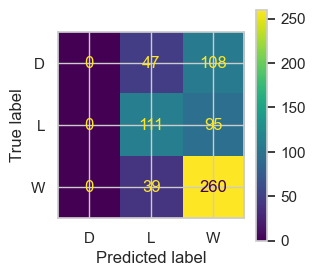

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [12]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5621212121212121
ROC score on Test Set: 0.6894577654709837

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.56      0.54      0.55       206
           2       0.56      0.87      0.68       299

    accuracy                           0.56       660
   macro avg       0.38      0.47      0.41       660
weighted avg       0.43      0.56      0.48       660



#### Fold 2

In [13]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


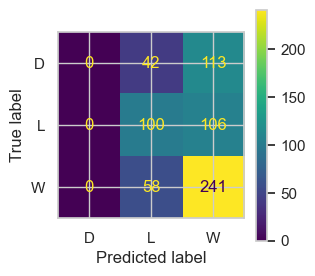

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [15]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5166666666666667
ROC score on Test Set: 0.6659037078552572

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.50      0.49      0.49       206
           2       0.52      0.81      0.64       299

    accuracy                           0.52       660
   macro avg       0.34      0.43      0.38       660
weighted avg       0.39      0.52      0.44       660



#### Fold 3

In [16]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


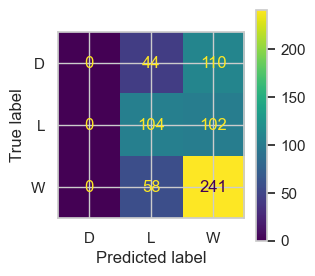

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5235204855842185
ROC score on Test Set: 0.6582911169751068

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.50      0.50      0.50       206
           2       0.53      0.81      0.64       299

    accuracy                           0.52       659
   macro avg       0.35      0.44      0.38       659
weighted avg       0.40      0.52      0.45       659



#### Fold 4

In [19]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


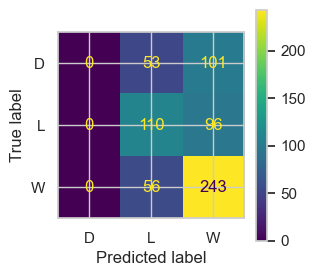

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [21]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5356600910470409
ROC score on Test Set: 0.6859670113922727

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.50      0.53      0.52       206
           2       0.55      0.81      0.66       299

    accuracy                           0.54       659
   macro avg       0.35      0.45      0.39       659
weighted avg       0.41      0.54      0.46       659



#### Fold 5

In [22]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1196
1     824
0     618
Name: Result, dtype: int64
2    300
1    205
0    154
Name: Result, dtype: int64


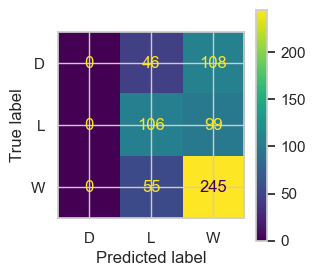

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [24]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5326251896813353
ROC score on Test Set: 0.6801999642746881

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.51      0.52      0.51       205
           2       0.54      0.82      0.65       300

    accuracy                           0.53       659
   macro avg       0.35      0.44      0.39       659
weighted avg       0.41      0.53      0.46       659



### Logistic Regression

#### Hyperparameter Tuning using Fold 1

In [8]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.0018329807108324356, 'penalty': 'l2', 'solver': 'liblinear'}


#### Fold 1

In [25]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0018, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


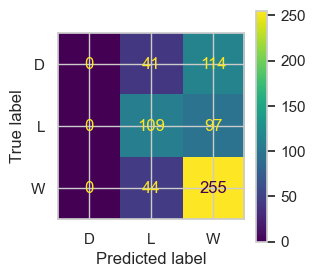

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [27]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5515151515151515
ROC score on Test Set: 0.6744808365359459

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.56      0.53      0.55       206
           2       0.55      0.85      0.67       299

    accuracy                           0.55       660
   macro avg       0.37      0.46      0.40       660
weighted avg       0.42      0.55      0.47       660



#### Fold 2

In [28]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0018, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


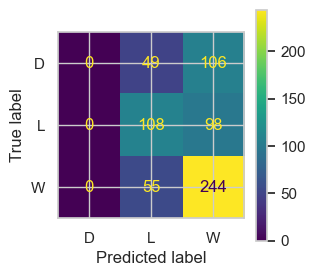

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [30]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5333333333333333
ROC score on Test Set: 0.6400517697565209

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.51      0.52      0.52       206
           2       0.54      0.82      0.65       299

    accuracy                           0.53       660
   macro avg       0.35      0.45      0.39       660
weighted avg       0.41      0.53      0.46       660



#### Fold 3

In [31]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0018, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


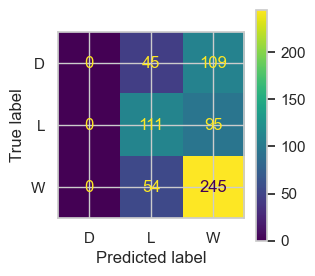

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [33]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5402124430955993
ROC score on Test Set: 0.6534691263697715

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.53      0.54      0.53       206
           2       0.55      0.82      0.66       299

    accuracy                           0.54       659
   macro avg       0.36      0.45      0.40       659
weighted avg       0.41      0.54      0.46       659



#### Fold 4

In [34]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0018, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


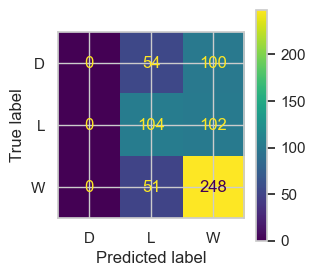

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [36]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5341426403641881
ROC score on Test Set: 0.6475493167049773

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.50      0.50      0.50       206
           2       0.55      0.83      0.66       299

    accuracy                           0.53       659
   macro avg       0.35      0.44      0.39       659
weighted avg       0.41      0.53      0.46       659



#### Fold 5

In [37]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0018, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1196
1     824
0     618
Name: Result, dtype: int64
2    300
1    205
0    154
Name: Result, dtype: int64


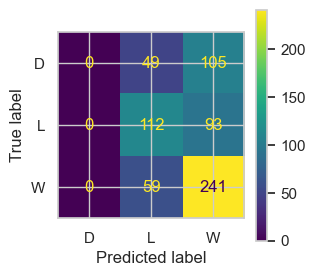

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [39]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5356600910470409
ROC score on Test Set: 0.6444974001141621

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.51      0.55      0.53       205
           2       0.55      0.80      0.65       300

    accuracy                           0.54       659
   macro avg       0.35      0.45      0.39       659
weighted avg       0.41      0.54      0.46       659



### SVM Classifier

#### Hyperparameter Tuning using Fold 1

In [9]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 0.1, 'tol': 0.1}


#### Fold 1

In [40]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


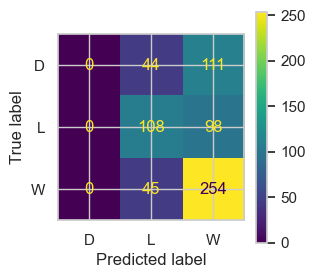

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [42]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5484848484848485
ROC score on Test Set: 0.6738948489831106

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.55      0.52      0.54       206
           2       0.55      0.85      0.67       299

    accuracy                           0.55       660
   macro avg       0.37      0.46      0.40       660
weighted avg       0.42      0.55      0.47       660



#### Fold 2

In [43]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


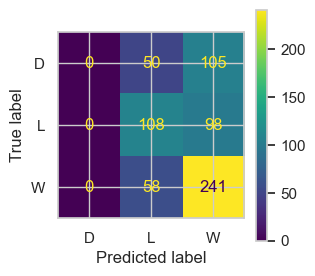

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [45]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5287878787878788
ROC score on Test Set: 0.6547567601586692

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.50      0.52      0.51       206
           2       0.54      0.81      0.65       299

    accuracy                           0.53       660
   macro avg       0.35      0.44      0.39       660
weighted avg       0.40      0.53      0.45       660



#### Fold 3

In [46]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


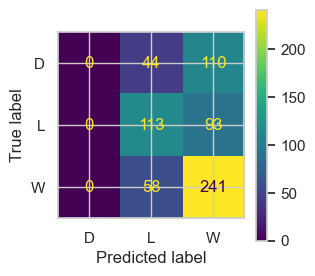

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [48]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5371775417298937
ROC score on Test Set: 0.6608550137390208

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.53      0.55      0.54       206
           2       0.54      0.81      0.65       299

    accuracy                           0.54       659
   macro avg       0.36      0.45      0.40       659
weighted avg       0.41      0.54      0.46       659



#### Fold 4

In [49]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


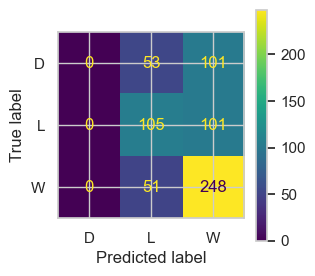

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [51]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5356600910470409
ROC score on Test Set: 0.6733197983396608

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.50      0.51      0.51       206
           2       0.55      0.83      0.66       299

    accuracy                           0.54       659
   macro avg       0.35      0.45      0.39       659
weighted avg       0.41      0.54      0.46       659



#### Fold 5

In [52]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1196
1     824
0     618
Name: Result, dtype: int64
2    300
1    205
0    154
Name: Result, dtype: int64


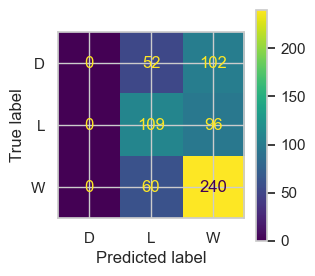

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [54]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5295902883156297
ROC score on Test Set: 0.6605918488352677

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.49      0.53      0.51       205
           2       0.55      0.80      0.65       300

    accuracy                           0.53       659
   macro avg       0.35      0.44      0.39       659
weighted avg       0.40      0.53      0.46       659



### XGBoost Classifier

#### Hyperparameter Tuning using Fold 1

In [7]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 140}


#### Fold 1

In [55]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


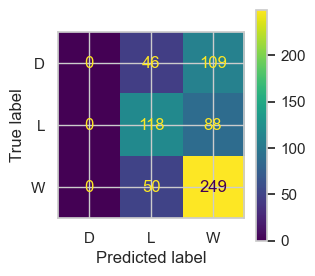

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [57]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.556060606060606
ROC score on Test Set: 0.6874107851557851

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.55      0.57      0.56       206
           2       0.56      0.83      0.67       299

    accuracy                           0.56       660
   macro avg       0.37      0.47      0.41       660
weighted avg       0.43      0.56      0.48       660



#### Fold 2

In [58]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1197
1     823
0     617
Name: Result, dtype: int64
2    299
1    206
0    155
Name: Result, dtype: int64


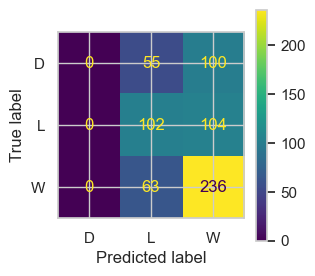

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [60]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5121212121212121
ROC score on Test Set: 0.6569267685643204

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.46      0.50      0.48       206
           2       0.54      0.79      0.64       299

    accuracy                           0.51       660
   macro avg       0.33      0.43      0.37       660
weighted avg       0.39      0.51      0.44       660



#### Fold 3

In [61]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


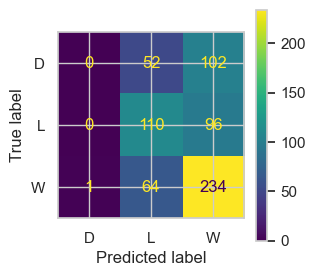

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [63]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5220030349013657
ROC score on Test Set: 0.6511593061923041

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.49      0.53      0.51       206
           2       0.54      0.78      0.64       299

    accuracy                           0.52       659
   macro avg       0.34      0.44      0.38       659
weighted avg       0.40      0.52      0.45       659



#### Fold 4

In [64]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1197
1     823
0     618
Name: Result, dtype: int64
2    299
1    206
0    154
Name: Result, dtype: int64


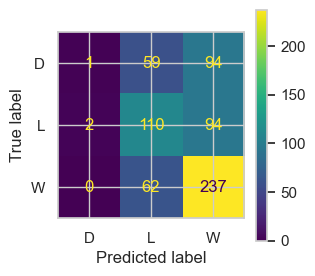

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [66]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5280728376327769
ROC score on Test Set: 0.6755539100172163

              precision    recall  f1-score   support

           0       0.33      0.01      0.01       154
           1       0.48      0.53      0.50       206
           2       0.56      0.79      0.65       299

    accuracy                           0.53       659
   macro avg       0.46      0.44      0.39       659
weighted avg       0.48      0.53      0.46       659



#### Fold 5

In [67]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=140)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wdl_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wdl_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1196
1     824
0     618
Name: Result, dtype: int64
2    300
1    205
0    154
Name: Result, dtype: int64


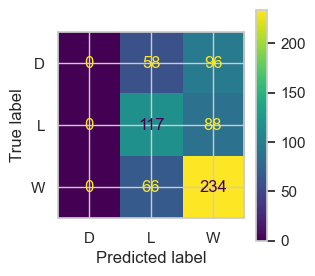

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [69]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5326251896813353
ROC score on Test Set: 0.6777932692025413

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.49      0.57      0.52       205
           2       0.56      0.78      0.65       300

    accuracy                           0.53       659
   macro avg       0.35      0.45      0.39       659
weighted avg       0.41      0.53      0.46       659

